# Credit Card Fraud Detection
## Anonymized credit card transactions labeled as fraudulent or genuine

**Context**

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content**

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

**Goal**

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we will use the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV
from sklearn.linear_model import Ridge

from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier,StackingClassifier,BaggingRegressor
import time
import datetime
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score,roc_auc_score
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from xgboost import XGBClassifier


In [7]:
#importation de la dataset
dataset =pd.read_csv("creditcard.csv")

In [13]:
dataset.head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [12]:
mask=dataset.Class==1
datafraud=dataset[mask]

In [16]:
# Basic stats
data_desc=datafraud.describe(include='all')
print(data_desc)
datafraud.shape

                Time          V1          V2          V3          V4  \
count     492.000000  492.000000  492.000000  492.000000  492.000000   
mean    80746.806911   -4.771948    3.623778   -7.033281    4.542029   
std     47835.365138    6.783687    4.291216    7.110937    2.873318   
min       406.000000  -30.552380   -8.402154  -31.103685   -1.313275   
25%     41241.500000   -6.036063    1.188226   -8.643489    2.373050   
50%     75568.500000   -2.342497    2.717869   -5.075257    4.177147   
75%    128483.000000   -0.419200    4.971257   -2.276185    6.348729   
max    170348.000000    2.132386   22.057729    2.250210   12.114672   

               V5          V6          V7          V8          V9  ...  \
count  492.000000  492.000000  492.000000  492.000000  492.000000  ...   
mean    -3.151225   -1.397737   -5.568731    0.570636   -2.581123  ...   
std      5.372468    1.858124    7.206773    6.797831    2.500896  ...   
min    -22.105532   -6.406267  -43.557242  -41.044261  

(492, 31)

In [25]:
datafraud.Amount.value_counts()

1.00      113
0.00       27
99.99      27
0.76       17
0.77       10
         ... 
323.77      1
57.73       1
3.93        1
2.47        1
175.90      1
Name: Amount, Length: 259, dtype: int64

***we have 492 frauds out of 284,807 transactions (0.172%)***

***27 frauds have an amount of 27***

In [8]:
col=dataset.columns
col

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [9]:
col=col.drop(['Class'])
col

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [10]:
features_list = col
target_variable = 'Class'

In [11]:
X = dataset.loc[:, features_list]
Y = dataset.loc[:, target_variable]

print('Variables explicatives : ', X.columns)
print()

Variables explicatives :  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')



In [12]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features.append(i)
    numeric_indices.append(idx)
  else :
    categorical_features.append(i)
    categorical_indices.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)


Found numeric features  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']  at positions  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Found categorical features  []  at positions  []


In [13]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [14]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[ 1.61919000e+05  1.94674667e+00 -7.52525821e-01 -1.35512953e+00
  -6.61629913e-01  1.50282191e+00  4.02493283e+00 -1.47966148e+00
   1.13988022e+00  1.40681871e+00 -1.57402913e-01 -1.13729190e-01
   5.10277474e-01  6.12577807e-02 -6.65551395e-02  1.32870182e+00
   3.52513903e-01 -7.65669827e-01  1.41937537e-01 -4.51364652e-01
  -1.34434695e-01  7.61965102e-02  2.97536541e-01  3.07914569e-01
   6.90980284e-01 -3.50316231e-01 -3.88907265e-01  7.76408382e-02
  -3.22477642e-02  7.32000000e+00]
 [ 1.24477000e+05  2.03514919e+00 -4.88803143e-02 -3.05869345e+00
   2.47945034e-01  2.94348685e+00  3.29869731e+00 -2.19246394e-03
   6.74781824e-01  4.58257088e-02  2.84864277e-01 -2.54903245e-01
   3.25559776e-01 -4.05326546e-01  7.21068408e-01 -1.48445145e-01
  -7.54029381e-01 -2.70842358e-01 -6.95697842e-01 -2.74411135e-01
  -2.27279116e-01  3.86282061e-02  2.28197020e-01  3.55424132e-02
   7.07089988e-01  5.12884596e-01 -4.71197625e-01  2.5

In [15]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

if categorical_indices==[]:
    # Normalization
    print("just scaling")
    featureencoder = StandardScaler()
    
elif numeric_indices==[]:
    # OHE / dummyfication
    print("encoding")
    featureencoder = OneHotEncoder(drop='first') 
    
else:

    # Normalization
    numeric_transformer = StandardScaler()

    # OHE / dummyfication
    categorical_transformer = OneHotEncoder(drop='first')
    featureencoder = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_indices),    
            ('num', numeric_transformer, numeric_indices)
            ]    )

X_train = featureencoder.fit_transform(X_train)

print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
just scaling
...Done
[[ 1.41158751e+00  9.93379083e-01 -4.56036586e-01 -8.94051557e-01
  -4.67283725e-01  1.08921729e+00  3.02438347e+00 -1.19485202e+00
   9.57057418e-01  1.28137638e+00 -1.44546401e-01 -1.10814578e-01
   5.09338566e-01  6.21173504e-02 -6.95576832e-02  1.45109663e+00
   4.04446404e-01 -9.07403516e-01  1.69133453e-01 -5.55365736e-01
  -1.73112388e-01  1.03171150e-01  4.09563109e-01  4.90684977e-01
   1.14196982e+00 -6.70831980e-01 -8.07226946e-01  1.91911522e-01
  -9.91057622e-02 -3.22493763e-01]
 [ 6.23140848e-01  1.03850725e+00 -2.93491180e-02 -2.01830171e+00
   1.75133177e-01  2.13350569e+00  2.47884001e+00 -1.83232506e-03
   5.66703699e-01  4.11208797e-02  2.62604208e-01 -2.49329490e-01
   3.23973351e-01 -4.07235825e-01  7.54324041e-01 -1.63023227e-01
  -8.61271777e-01 -3.21276918e-01 -8.29392525e-01 -3.37959105e-01
  -2.93563756e-01  5.20550968e-02  3.14019107e-01  5.65684612e-02
   1.16858333e+0

In [16]:
classifier =  XGBClassifier(
    n_jobs=-1
)

classifier.fit(X_train, Y_train)
print("...Done.")

...Done.


In [17]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [18]:
print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 1.3871815  -0.34471083  0.85416023 -0.73269126 -0.93818762  1.00670883
  -0.98201123  1.52273861 -0.51515709  0.28336517  0.59944458 -0.84085508
  -0.23349522 -0.20050673  0.27869502 -0.05167318 -0.84682349 -0.7178194
  -0.4680386  -0.20064633  0.51286793  0.10846086  1.11574075 -0.3576211
   1.16992023 -0.25934891  0.09332341  1.31850867  0.89058207 -0.25995439]
 [-1.58013819 -1.44498471 -1.67648235  1.67504412 -0.75894346  2.06034649
  -1.61684295 -1.44989904 -0.2094761   2.80020559 -0.92062496  1.81675188
  -1.55793919  1.26026452  1.00841216 -0.52644498 -0.16728705 -0.24841293
   1.26222093  0.48701189 -0.66782946 -0.40263949  0.1501959  -1.29630236
   0.07148752 -0.05180832 -1.88898386  0.27380388 -1.56632492 -0.30442595]
 [-0.13812017 -1.82615312  1.40617205  0.86278481  2.30508347  0.81739017
   2.15323428  1.16603298 -0.6030217   1.70715436  6.81139967  2.04271776
  -0.06709726  0.58147932 -2.54201

In [19]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [20]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  1.0
f1-score on test set :  0.8695652173913043


CONFUSION MATRIX ON TEST SET


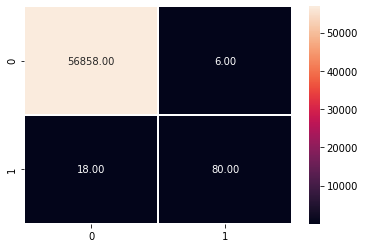

In [21]:
print("CONFUSION MATRIX ON TEST SET")
cm2=confusion_matrix(Y_test,Y_test_pred)
sns.heatmap(cm2, annot=True, annot_kws={"size": 10}, fmt=".2f", linewidths=1)